In [1]:
import time
import itertools
import datetime as dt

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import seaborn as sns
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.scaler import STMatrixStandardScaler
from utils.helper import format_stmatrix, train_test_split, fix_seed
from dataset import STDataset
from trainer import Trainer
from logger import Logger
import config

In [103]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=3)

## 前処理してデータセットを作成
- 渋滞量 -> フラグに変換
- 方向 -> 0/1に変換
    - 上り: 0, 下り: 1
- 四半期を数値化
- 使用しないカラムを落とす
    - 天気 + `index`, `data`, `road_code`, `jam_type`
- 速度の欠損を埋める
- OCC -> [0, 1]に変換
- 型変換
    - float64 -> float32
    - 区間の名前, コード, 県コード, 0/1系, カレンダーデータをcategoryデータに
    - degreeをint32

In [3]:
# 道路名
# TARGET_ROAD='tateyama'
TARGET_ROAD='kannetsu'

# 交通量
PROCESSED_DATA_DIR = '../Input_processed_data'
TRAFFIC_DIR = f'{PROCESSED_DATA_DIR}/traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_20220621all-merged_filled_1h.csv'

In [4]:
col_types = {'start_code': str, 'end_code': str, 'road_code': str, 'jam_type': str,}

df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime', dtype=col_types).reset_index()

In [5]:
def linear_interpolate(df, col):
    '''
    dfのcolカラム内の欠損を区間ごとに線形補間する
    '''
    f = lambda g: g.interpolate(method='linear', axis=0)
    
    df.sort_values('datetime', inplace=True)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df


def preprocess(df):
    # 「年」情報を入れる
    df['year'] = df['datetime'].dt.year
    # 渋滞フラグ 0/1
    df['jam_flag'] = np.where(df['speed'] < 40, 1, 0)
    # 方向を数値化
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    # 四半期を数値化
    df['quarter'] = df['quarter'].str[-1]
    
    # object型のカラム, いらないカラムを落とす
    drop_cols = [
        'index', 'date', 'road_code', 'pressure', 'rainfall', 
        'temperature', 'humidity', 'wind_speed', 'daylight_hours', 
        'snowfall', 'deepest_snowfall', 'weather_description', 'jam_type'
    ]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # 速度の欠損を埋める
    df = linear_interpolate(df, 'speed')
    # OCCを[0,1]に変換
    df['OCC'] = df['OCC'] / 100.0
    
    # 型変換
    f64_cols = df.select_dtypes(include=[np.float64]).columns
    df.loc[:, f64_cols] = df.loc[:, f64_cols].astype(np.float32)
    i64_cols = df.select_dtypes(include=[int]).columns
    df.loc[:, i64_cols] = df.loc[:, i64_cols].astype(np.int32)
    
    type_map = {
        'start_name': 'category',
        'end_name': 'category',
        'start_code': 'category',
        'end_code': 'category',
        'start_pref_code': 'category',
        'end_pref_code': 'category',
        'direction': 'category',
        'month': 'category',
        'day': 'category',
        'dayofweek': 'category',
        'is_holiday': 'category',
        'hour': 'category',
        'quarter': 'category',
        'jam_quantity': 'category',
        'start_degree': np.int32,
        'end_degree': np.int32,
        'degree_sum': np.int32,
    }
    df = df.astype(type_map)
    
    return df

In [7]:
def create_dataset(df, start_date, end_date, pkl_name):
    tmp = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
    # tmp.reset_index(drop=True, inplace=True)
    
    tmp = preprocess(tmp.copy())
    tmp.reset_index(drop=True, inplace=True)
    
    tmp.to_pickle(pkl_name)

# whole dataset
start_date = '2021/4/2'
end_date = '2022/6/1'
pkl_name = f'./datasets/jam/kannetsu_210402-220531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

# mini dataset
start_date = '2021/4/2'
end_date = '2021/6/1'
pkl_name = './datasets/jam/kannetsu_210402-210531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

## データセットを読み込む

In [26]:
# mini
df_test = pd.read_pickle('./datasets/jam/kannetsu_210402-210531.pkl')
# whole
df_all = pd.read_pickle('./datasets/jam/kannetsu_210402-220531.pkl')

In [27]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

In [28]:
df_test.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,search_unspec_1d,search_unspec_3d,search_unspec_7d,search_unspec_10d,allCars,jam_quantity,OCC,speed,year,jam_flag
0,2021-04-02,所沢,大泉ＪＣＴ,1800006,1110210,11,13,35.806149,35.755821,139.535507,...,2156.0,2156.0,2156.0,2156.0,630.0,0,0.02,87.298416,2021,0
1,2021-04-02,小出,大和ＰＡ,1800156,1800151,15,15,37.213329,37.160999,138.975403,...,749.0,749.0,749.0,749.0,67.0,0,0.00,90.970146,2021,0
2,2021-04-02,六日町,塩沢石打,1800146,1800141,15,15,37.077942,36.990280,138.879288,...,705.0,705.0,705.0,705.0,60.0,0,0.00,87.633331,2021,0


### 時間, 区間にembedding用のIDを割り振る

In [ ]:
# 時間情報を管理するためのテーブルを作成 (month x hour x dayofweeks x is_holidays)
# months = range(1, 12+1)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(months, hours, dayofweeks, is_holidays), columns=['month', 'hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['month', 'hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/datetime_table.pkl')

In [ ]:
# 時間情報を管理するためのテーブルを作成 (hour x dayofweeks x is_holidays)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(hours, dayofweeks, is_holidays), columns=['hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/mini_datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/mini_datetime_table.pkl')

In [ ]:
# 区間情報を管理するためのテーブルを作成
# sec_table = df_test[['start_name', 'end_name', 'direction', 'KP']].drop_duplicates()
# 区間順にソート
# sort_f = lambda g: g.sort_values('KP', ascending=(g.name == 1))
# sec_table = sec_table.groupby('direction').apply(sort_f).reset_index(drop=True)

# sec_table.to_pickle('./datasets/section_table.pkl')
# sec_table.head(3)

# sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [29]:
def datetime2id(df, dt_table):
    time_col = ['hour', 'dayofweek', 'is_holiday']
    f = lambda g: g.assign(datetime_id=dt_table.loc[g.name, 'index'])
    df = df.groupby(time_col).apply(f)
    df['datetime_id'] = df['datetime_id'].astype('category')
    return df


def section2id(df, sec_table):
    f = lambda g: g.assign(section_id=sec_table.query(f'start_name == "{g.name[0]}" & end_name == "{g.name[1]}"').index.item())
    df = df.groupby(['start_name', 'end_name']).apply(f)
    df['section_id'] = df['section_id'].astype('category')
    return df


def identify(df, dt_table, sec_table):
    df = datetime2id(df, dt_table)
    df = section2id(df, sec_table)
    return df

In [31]:
df_test = identify(df_test, dt_table, sec_table)
df_test.to_pickle('./datasets/jam/kannetsu_210402-210531.pkl')

df_all = identify(df_all, dt_table, sec_table)
df_all.to_pickle('./datasets/jam/kannetsu_210402-220531.pkl')

## Spatial Temporal Matrixに整形
- 区間数 x 時系列数 の行列
- 実際は 区間数 x 時系列数 x 特徴量数 のテンソル

In [35]:
# # mini
# df_test = pd.read_pickle('./datasets/jam/kannetsu_210402-210531.pkl')
# # whole
# df_all = pd.read_pickle('./datasets/jam/kannetsu_210402-220531.pkl')

# df_test_tr = df_test[df_test['datetime'] < pd.Timestamp('2021/5/20')].reset_index(drop=True)
# df_test_va = df_test[df_test['datetime'] >= pd.Timestamp('2021/5/20')].reset_index(drop=True)
# df_test_tr.to_pickle('./datasets/jam/kannetsu_210402-210519.pkl')
# df_test_va.to_pickle('./datasets/jam/kannetsu_210520-210531.pkl')

# df_all_tr = df_all[df_all['datetime'] < pd.Timestamp('2022/3/1')].reset_index(drop=True)
# df_all_va = df_all[df_all['datetime'] >= pd.Timestamp('2022/3/1')].reset_index(drop=True)
# df_all_tr.to_pickle('./datasets/jam/kannetsu_210402-220228.pkl')
# df_all_va.to_pickle('./datasets/jam/kannetsu_220301-220531.pkl')

In [3]:
df_test_tr = pd.read_pickle('./datasets/jam/kannetsu_210402-210519.pkl')
df_test_va = pd.read_pickle('./datasets/jam/kannetsu_210520-210531.pkl')

df_all_tr = pd.read_pickle('./datasets/jam/kannetsu_210402-220228.pkl')
df_all_va = pd.read_pickle('./datasets/jam/kannetsu_220301-220531.pkl')

dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

In [5]:
# 特徴量の元になる列
time_col = ['datetime_id']
section_col = ['section_id']
search_col = ['search_1h', 'search_unspec_1d']
traffic_col = ['allCars', 'speed', 'OCC', 'jam_quantity']

feature_col = time_col + section_col + search_col + traffic_col

# 予測対象
target_col = 'jam_quantity'

In [6]:
df_all_tr[target_col] = df_all_tr[target_col].astype(np.int64)
df_all_va[target_col] = df_all_va[target_col].astype(np.int64)

df_test_tr[target_col] = df_test_tr[target_col].astype(np.int64)
df_test_va[target_col] = df_test_va[target_col].astype(np.int64)

In [11]:
X_tr, y_tr = format_stmatrix(df_test_tr, sec_table, feature_col, target_col)
X_va, y_va = format_stmatrix(df_test_va, sec_table, feature_col, target_col)
print(X_tr.shape, X_va.shape, y_tr.shape, y_va.shape)

torch.Size([8, 1152, 63]) torch.Size([8, 288, 63]) torch.Size([1, 1152, 63]) torch.Size([1, 288, 63])


In [13]:
# torch.save(X_tr, './datasets/jam/features_train.pkl')
# torch.save(X_va, './datasets/jam/features_test.pkl')
# torch.save(y_tr, './datasets/jam/labels_train.pkl')
# torch.save(y_va, './datasets/jam/labels_test.pkl')

# torch.save(X_tr, './datasets/jam/mini_features_train.pkl')
# torch.save(X_va, './datasets/jam/mini_features_test.pkl')
# torch.save(y_tr, './datasets/jam/mini_labels_train.pkl')
# torch.save(y_va, './datasets/jam/mini_labels_test.pkl')

## 標準化・正規化
- 標準化を行う
- 時間特徴量（`month`, `hour`, `day_of_week`）はsin, cosで変換するのもやってみる
- 検索数, 台数は上り・下り別でもやってみる

In [19]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load('./datasets/jam/features_train.pkl')
X_va = torch.load('./datasets/jam/features_test.pkl')
y_tr = torch.load('./datasets/jam/labels_train.pkl')
y_va = torch.load('./datasets/jam/labels_test.pkl')

# X_tr = torch.load('./datasets/jam/mini_features_train.pkl')
# X_va = torch.load('./datasets/jam/mini_features_test.pkl')
# y_tr = torch.load('./datasets/jam/mini_labels_train.pkl')
# y_va = torch.load('./datasets/jam/mini_labels_test.pkl')

print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

torch.Size([8, 7992, 63]) torch.Size([8, 2208, 63])
torch.Size([1, 7992, 63]) torch.Size([1, 2208, 63])


In [18]:
# ID列は飛ばして標準化
skip_features = [0, 1, -1]
scaler = STMatrixStandardScaler(skip_features=skip_features)

scaler.fit(X_tr)
X_tr_norm = scaler.transform(X_tr)

scaler.fit(X_va)
X_va_norm = scaler.transform(X_va)

# torch.save(X_tr_norm, './datasets/jam/mini_features_train_norm.pkl')
# torch.save(X_va_norm, './datasets/jam/mini_features_test_norm.pkl')

## データセットの定義

In [3]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load(f'{config.DATASET_DIR}/jam/features_train_norm.pkl')
X_va = torch.load(f'{config.DATASET_DIR}/jam/features_test_norm.pkl')
y_tr = torch.load(f'{config.DATASET_DIR}/jam/labels_train.pkl')
y_va = torch.load(f'{config.DATASET_DIR}/jam/labels_test.pkl')

# X_tr = torch.load(f'{config.MINI_DIR}/jam/mini_features_train_norm.pkl')
# X_va = torch.load(f'{config.MINI_DIR}/jam/mini_features_test_norm.pkl')
# y_tr = torch.load(f'{config.MINI_DIR}/jam/mini_labels_train.pkl')
# y_va = torch.load(f'{config.MINI_DIR}/jam/mini_labels_test.pkl')

print(dt_table.shape, sec_table.shape)
print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

(288, 1) (63, 4)
torch.Size([8, 7992, 63]) torch.Size([8, 2208, 63])
torch.Size([1, 7992, 63]) torch.Size([1, 2208, 63])


In [4]:
time_step = 168
prediction_horizon = 24
space_window = (-2, 2)
static_col = config.STATIC_COL

dataset_train = STDataset(X_tr, y_tr, 
                          time_step=time_step, 
                          prediction_horizon=prediction_horizon,
                          space_window=space_window, 
                          static_col=static_col)

dataset_valid = STDataset(X_va, y_va, 
                          time_step=time_step, 
                          prediction_horizon=prediction_horizon,
                          space_window=space_window, 
                          static_col=static_col)

## Networkの定義

### HA

In [19]:
class HA:
    def forward(self, x):
        out = x[:, -1].mean(dim=1)
        return out
    
    def __call__(self, x):
        return self.forward(x)

### LSTM

In [10]:
class SimpleLSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, num_layers, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(in_dim, hid_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, 1)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        outs, (h, c) = self.lstm(x)
        out = self.fc(h[0])
        return out
    

class LSTM(nn.Module):
    def __init__(self, hid_dim, num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        self.search_lstm = nn.LSTM(2, hid_dim, num_layers, batch_first=batch_first)
        
        self.fc = nn.Linear(hid_dim * 2, 1)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        outs, (h, c) = self.lstm(x[..., -1:])
        s_outs, (s_h, s_c) = self.search_lstm(x[..., -3:-1])
        out = torch.cat([h[0], s_h[0]], dim=1)
        out = self.fc(out)
        return out

### Embedding + LSTM

In [ ]:
class LSTM_Embedding(nn.Module):
    def __init__(self, hid_dim, num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        
        self.dt_n_embed = 32
        self.road_n_embed = 16
        self.n_embed = self.dt_n_embed + self.road_n_embed
        self.dt_embed = nn.Embedding(len(dt_table), self.dt_n_embed)
        self.road_embed = nn.Embedding(len(sec_table), self.road_n_embed)
        
        self.traffic_lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        self.search_lstm = nn.LSTM(2, hid_dim, num_layers, batch_first=batch_first)
        
        self.cat_fc = nn.Linear(self.n_embed, 16)
        self.fc1 = nn.Linear(hid_dim * 2 + 16, 32)
        self.fc2 = nn.Linear(32, 1)
        
        
    def forward(self, x):  
        x_dy, x_st = x
        
        # categorical (datetime + road)
        dt_emb = self.dt_embed(x_st[..., 0].to(dtype=torch.int64))
        road_emb = self.road_embed(x_st[..., 1].to(dtype=torch.int64))
        cat_emb = torch.cat([dt_emb, road_emb], dim=1)
        cat_out = F.relu(self.cat_fc(cat_emb))
        
        # traffic
        x_dy = x_dy.permute(0, 2, 1)
        _, (traffic_h, _) = self.traffic_lstm(x_dy[..., -1:])
        
        # search
        _, (search_h, _) = self.search_lstm(x_dy[..., -3:-1])
        # linear
        out = torch.cat([traffic_h[0], search_h[0], cat_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### Conv1d + LSTM

In [32]:
class Conv1dLSTM(nn.Module):
    def __init__(self, hid_dim, kernel_size, num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        
        self.conv = nn.Conv1d(96, 96, 5)
        self.lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        
        self.search_conv1 = nn.Conv1d(96, 96, 5)
        self.search_conv2 = nn.Conv1d(96, 96, 5)
        self.search_fc = nn.Linear(96*2, 64)
        
        self.fc1 = nn.Linear(hid_dim + 64, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        N, D, T, S = x.shape
        
        # traffic
        out = F.relu(self.conv(x[:, -1]))
        _, (h, c) = self.lstm(out)
        
        # search
        s_out1 = F.relu(self.search_conv1(x[:, -3]))
        s_out1 = s_out1.view(N, -1)
        s_out2 = F.relu(self.search_conv2(x[:, -2]))
        s_out2 = s_out2.view(N, -1)
        s_out = torch.cat([s_out1, s_out2], dim=1)
        s_out = F.relu(self.search_fc(s_out))
        
        # concat
        out = torch.cat([h[0], s_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

### Conv2d + LSTM

In [ ]:
class Conv2dLSTM(nn.Module):
    def __init__(self, hid_dim, kernel_size, num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = (4, 0)
        
        self.conv1 = nn.Conv2d(1, 32, (9, 3), padding=self.padding)
        self.conv2 = nn.Conv2d(32, 16, (9, 3), padding=self.padding)
        self.lstm = nn.LSTM(16, hid_dim, num_layers, batch_first=batch_first)
        
        self.search_conv1 = nn.Conv2d(2, 64, (9, 3), padding=self.padding)
        self.search_conv2 = nn.Conv2d(64, 32, (9, 3), padding=self.padding)
        self.search_fc = nn.Linear(32 * 96, 64)
        
        self.fc1 = nn.Linear(hid_dim + 64, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        N, D, T, S = x.shape   
        # traffic
        out = F.relu(self.conv1(x[:, -1:]))
        out = F.relu(self.conv2(out))
        out = out[..., 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        
        # search feature
        s_out = F.relu(self.search_conv1(x[:, -3:-1]))
        s_out = F.relu(self.search_conv2(s_out))
        s_out = s_out.view(N, -1)
        s_out = F.relu(self.search_fc(s_out))
        
        # predict
        out = torch.cat([h[0], s_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

### Embedding + Conv2d + LSTM

In [87]:
# normal
# EMB_DIM = 16
# CONV_DIM = 32 # 32->16
# LSTM_DIM = 64
# LSTM_LAYERS = 1
# SEARCH_CONV_DIM = 64 # 64->32
# SEARCH_FC_DIM = 32
# FC1_DIM = 32

# wide
# EMB_DIM = 16
# CONV_DIM = 64
# LSTM_DIM = 64
# LSTM_LAYERS = 1
# SEARCH_CONV_DIM = 64
# SEARCH_FC_DIM = 128
# FC1_DIM = 64

# wide2
EMB_DIM = 16
CONV_DIM = 64
LSTM_DIM = 128
LSTM_LAYERS = 2
SEARCH_CONV_DIM = 64
SEARCH_FC_DIM = 128
FC1_DIM = 128

In [104]:
class Conv2dLSTM_Embedding(nn.Module):
    def __init__(self, hid_dim, kernel_size, padding=(4,0), num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = padding
        
        # categorical
        self.dt_n_embed = 32
        self.road_n_embed = 16
        self.n_embed = self.dt_n_embed + self.road_n_embed
        self.dt_embed = nn.Embedding(len(dt_table), self.dt_n_embed)
        self.road_embed = nn.Embedding(len(sec_table), self.road_n_embed)
        self.cat_fc = nn.Linear(self.n_embed, EMB_DIM)
        self.cat_bn = nn.BatchNorm1d(EMB_DIM)
        
        # traffic
        self.conv1 = nn.Conv2d(4, CONV_DIM, (9, 3), padding=self.padding)
        self.bn1 = nn.BatchNorm2d(CONV_DIM)
        self.conv2 = nn.Conv2d(CONV_DIM, CONV_DIM, (9, 3), padding=self.padding)
        self.bn2 = nn.BatchNorm2d(CONV_DIM)
        self.lstm = nn.LSTM(CONV_DIM, hid_dim, num_layers, batch_first=batch_first)
        
        # search
        self.search_conv1 = nn.Conv2d(2, SEARCH_CONV_DIM, (9, 3), padding=self.padding)
        self.search_bn1 = nn.BatchNorm2d(SEARCH_CONV_DIM)
        self.search_conv2 = nn.Conv2d(SEARCH_CONV_DIM, SEARCH_CONV_DIM, (9, 3), padding=self.padding)
        self.search_bn2 = nn.BatchNorm2d(SEARCH_CONV_DIM)
        self.search_fc = nn.Linear(SEARCH_CONV_DIM * 168, SEARCH_FC_DIM)
        self.search_bn3 = nn.BatchNorm1d(SEARCH_FC_DIM)
        
        # linear (traffic + search + categorical)
        self.fc1 = nn.Linear(hid_dim + SEARCH_FC_DIM + EMB_DIM, FC1_DIM)
        self.bn3 = nn.BatchNorm1d(FC1_DIM)
        self.fc2 = nn.Linear(FC1_DIM, 2)
        
        # dropout
        self.embed_dropout = nn.Dropout(p=0.8)
        self.dropout = nn.Dropout(p=0.6)
        self.last_dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):  
        x_dy, x_st = x
        N, D, T, S = x_dy.shape
        
        # categorical (datetime + road)
        dt_emb = self.dt_embed(x_st[..., 0].to(dtype=torch.int64))
        road_emb = self.road_embed(x_st[..., 1].to(dtype=torch.int64))
        cat_emb = torch.cat([dt_emb, road_emb], dim=1)
        cat_out = F.relu(self.cat_bn(self.cat_fc(cat_emb)))
        cat_out = self.embed_dropout(cat_out)
        
        # traffic
        out = F.relu(self.bn1(self.conv1(x_dy[:, -4:])))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.dropout(out)
        out = out[..., 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        h = self.dropout(h)
        
        # search
        s_out = F.relu(self.search_bn1(self.search_conv1(x_dy[:, -6:-4])))
        s_out = self.dropout(s_out)
        s_out = F.relu(self.search_bn2(self.search_conv2(s_out)))
        s_out = self.dropout(s_out)
        s_out = s_out.view(N, -1)
        s_out = F.relu(self.search_bn3(self.search_fc(s_out)))
        s_out = self.dropout(s_out)
        
        # linear
        out = torch.cat([h[0], s_out, cat_out], dim=1)
        out = F.relu(self.bn3(self.fc1(out)))
        out = self.last_dropout(out)
        out = self.fc2(out)
        
        return out

In [5]:
class Conv2dLSTM_Embedding(nn.Module):
    def __init__(self, hid_dim, kernel_size, padding=(4,0), num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = padding
        
        # categorical
        self.dt_n_embed = 32
        self.road_n_embed = 16
        self.n_embed = self.dt_n_embed + self.road_n_embed
        self.dt_embed = nn.Embedding(len(dt_table), self.dt_n_embed)
        self.road_embed = nn.Embedding(len(sec_table), self.road_n_embed)
        self.cat_fc = nn.Linear(self.n_embed, 16)
        
        # traffic
        self.conv1 = nn.Conv2d(4, 32, (9, 3), padding=self.padding)
        self.conv2 = nn.Conv2d(32, 16, (9, 3), padding=self.padding)
        self.lstm = nn.LSTM(16, hid_dim, num_layers, batch_first=batch_first)
        
        # search
        self.search_conv1 = nn.Conv2d(2, 64, (9, 3), padding=self.padding)
        self.search_conv2 = nn.Conv2d(64, 32, (9, 3), padding=self.padding)
        self.search_fc = nn.Linear(32 * 168, 64)
        
        # linear (traffic + search + categorical)
        self.fc1 = nn.Linear(hid_dim + 64 + 16, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):  
        x_dy, x_st = x
        N, D, T, S = x_dy.shape
        
        # categorical (datetime + road)
        dt_emb = self.dt_embed(x_st[..., 0].to(dtype=torch.int64))
        road_emb = self.road_embed(x_st[..., 1].to(dtype=torch.int64))
        cat_emb = torch.cat([dt_emb, road_emb], dim=1)
        cat_out = F.relu(self.cat_fc(cat_emb))
        
        # traffic
        out = F.relu(self.conv1(x_dy[:, -4:]))
        out = F.relu(self.conv2(out))
        out = out[..., 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        
        # search
        s_out = F.relu(self.search_conv1(x_dy[:, -6:-4]))
        s_out = F.relu(self.search_conv2(s_out))
        s_out = s_out.view(N, -1)
        s_out = F.relu(self.search_fc(s_out))
        
        # linear
        out = torch.cat([h[0], s_out, cat_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

## 学習

In [60]:
class CTrainer(Trainer):
    def __init__(
        self,
        model,
        optimizer,
        loss_fn,
        device=None,
        logger=None,
        model_name=None,
    ):
        super().__init__(model, optimizer, loss_fn, device, logger, model_name)

        self.train_accs = []
        self.val_accs = []
        self.best_acc = 0.0

    def fit(
        self,
        train_loader,
        val_loader,
        n_epochs,
        log_steps=None,
        max_first_log_steps=3,
        max_time=None,
        save_epoch_steps=None,
        random_seed=config.RANDOM_SEED,
    ):
        fix_seed(random_seed)
        start = time.time()

        for epoch in range(1, n_epochs + 1):
            ## increment epoch
            self.current_epoch += 1

            ## train
            self.model.train()
            epoch_start = time.time()

            train_loss, train_acc = self.__train_epoch(train_loader)
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            
            train_time = time.time() - epoch_start

            ## validate
            self.model.eval()
            epoch_start = time.time()

            val_loss, val_acc = self.__valid_epoch(val_loader)
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            val_time = time.time() - epoch_start

            ## logging
            log_flag = (self.logger is not None) and (log_steps is not None)
            if log_flag and (
                (self.current_epoch <= max_first_log_steps)
                or (self.current_epoch % log_steps == 0)
            ):
                message = f"Epoch: {self.current_epoch} | Train Loss: {train_loss:.3f}, Train F1: {train_acc:.3f}, Train Time: {train_time:.2f} [sec] | Valid Loss: {val_loss:.3f}, Valid F1: {val_acc:.3f}, Valid Time: {val_time:.2f} [sec]"
                self.__logging(message)

            if (self.model_name is not None) and (val_acc > self.best_acc):
                self.best_acc = val_acc
                self.save(self.model_name)

            ## early stopping
            if (max_time is not None) and (time.time() - start >= max_time):
                break

        return self.train_losses, self.val_losses

    def validate(self, loader):
        """1epochだけ回して性能を評価"""
        self.model.eval()

        total_loss, total_acc = self.__valid_epoch(loader)
        return total_loss, total_acc

    def predict(self):
        return

    def __train_epoch(self, loader):
        train_loss = 0.0
        
        ep_target = []
        ep_predicted = []

        for i_batch, (data, target) in enumerate(loader):
            if isinstance(data, (list, tuple)):
                data = map(lambda x: x.to(device=self.device), data)
            else:
                data = data.to(device=self.device)
            target = target.to(device=self.device)
            target_o = F.one_hot(target[:, 0].long(), num_classes=2).float()

            out = self.model(data)
            loss = self.loss_fn(out, target_o)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            _, predicted = torch.max(out.detach(), dim=1)

            train_loss += loss.item()
            ep_target.append(target[:, 0])
            ep_predicted.append(predicted)

        train_loss /= len(loader)
        
        ep_target = torch.cat(ep_target).cpu()
        ep_predicted = torch.cat(ep_predicted).cpu()
        train_acc = f1_score(ep_target, ep_predicted)
        
        return train_loss, train_acc

    def __valid_epoch(self, loader):
        valid_loss = 0.0
        
        ep_target = []
        ep_predicted = []
        
        with torch.no_grad():
            for i_batch, (data, target) in enumerate(loader):
                if isinstance(data, (list, tuple)):
                    data = map(lambda x: x.to(device=self.device), data)
                else:
                    data = data.to(device=self.device)
                target = target.to(device=self.device)
                target_o = F.one_hot(target[:, 0].long(), num_classes=2).float()

                out = self.model(data)
                loss = self.loss_fn(out, target_o)
                _, predicted = torch.max(out, dim=1)

                valid_loss += loss.item()
                ep_target.append(target[:, 0])
                ep_predicted.append(predicted)

            valid_loss /= len(loader)
            
            ep_target = torch.cat(ep_target).cpu()
            ep_predicted = torch.cat(ep_predicted).cpu()
            valid_acc = f1_score(ep_target, ep_predicted)
            
        return valid_loss, valid_acc
    
    def __logging(self, message):
        self.logger.log(message)
        return

In [61]:
class BalancedLoader:
    def __init__(self, dataset, batch_size):
        self.features = dataset[:][0][0]
        self.static_features = dataset[:][0][1]
        self.labels = dataset[:][1]
        assert batch_size % 2 == 0
        self.batch_size = batch_size
        self.n_samples = batch_size // 2
        
        label_counts = np.bincount(self.labels.view(-1).long())
        if label_counts.shape[0] != 2:
            raise ValueError(f'Expected 2 class but got {label_counts.shape[0]} class')
        if label_counts.min() < self.n_samples:
            raise ValueError('`n_samples` must be less than minor label data size')
            
        major_label = label_counts.argmax()
        minor_label = label_counts.argmin()
        self.major_indices = np.where(self.labels == major_label)[0]
        self.minor_indices = np.where(self.labels == minor_label)[0]
        
        np.random.shuffle(self.major_indices)
            
    def __iter__(self):
        count = 0
        while count + self.n_samples < len(self.major_indices):
            mini_major_indices = self.major_indices[count:count+self.n_samples]
            mini_minor_indices = np.random.choice(self.minor_indices, self.n_samples, replace=False)
            mini_indices = mini_major_indices.tolist() + mini_minor_indices.tolist()
            
            features = self.features[mini_indices]
            static_features = self.static_features[mini_indices]
            labels = self.labels[mini_indices]
            yield (features, static_features),labels
            
            count += self.n_samples
    
    def __len__(self):
        return len(self.labels) // self.batch_size

In [89]:
batch_size = config.BATCH_SIZE

train_loader = BalancedLoader(dataset_train, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

### HA

In [63]:
# data
X_tr = torch.load('./datasets/features_train.pkl')
X_va = torch.load('./datasets/features_test.pkl')

# dataset
time_step = 12
prediction_horizon = 1
space_window = None
static_col = None

dataset_train = STDataset(X_tr, y_tr, 
                          time_step=time_step, 
                          prediction_horizon=prediction_horizon,
                          space_window=space_window, 
                          static_col=static_col)

dataset_valid = STDataset(X_va, y_va, 
                          time_step=time_step, 
                          prediction_horizon=prediction_horizon,
                          space_window=space_window, 
                          static_col=static_col)

# loader
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [64]:
model = HA()
loss_fn = nn.L1Loss()

logger = Logger(f'{config.LOG_DIR}/HA.log')

val_loss = 0.0
for d, t in val_loader:
    out = model(d)
    loss = loss_fn(out, t)
    val_loss += loss.item()
    
val_loss /= len(val_loader)

msg = f'Time Step: {time_step} | Loss: {val_loss}'
logger.log(msg)

2022-08-14 03:45:28.889208 | Time Step: 12 | Loss: 56.652441359661495


---
### LSTM

In [19]:
# hyper parameters
n_epochs = 30
hid_dim = 64

# path
log_path = './logs/LSTM.log'
# log_path = None

model = LSTM(hid_dim).to(device=device)
model_name = 'LSTM'
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [20]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=5, max_first_log_steps=5)

2022-08-12 16:43:49.212220 | Epoch: 1 | Train Loss: 84.481, Train Time: 52.79 [sec] | Valid Loss: 26.293, Valid Time: 3.44 [sec]
2022-08-12 16:44:45.271707 | Epoch: 2 | Train Loss: 20.682, Train Time: 52.62 [sec] | Valid Loss: 19.820, Valid Time: 3.44 [sec]
2022-08-12 16:45:41.675216 | Epoch: 3 | Train Loss: 17.737, Train Time: 52.96 [sec] | Valid Loss: 18.742, Valid Time: 3.44 [sec]
2022-08-12 16:46:38.149782 | Epoch: 4 | Train Loss: 17.210, Train Time: 53.03 [sec] | Valid Loss: 17.337, Valid Time: 3.44 [sec]
2022-08-12 16:47:33.647089 | Epoch: 5 | Train Loss: 16.956, Train Time: 52.06 [sec] | Valid Loss: 18.391, Valid Time: 3.44 [sec]
2022-08-12 16:52:14.797811 | Epoch: 10 | Train Loss: 16.408, Train Time: 52.68 [sec] | Valid Loss: 17.449, Valid Time: 3.43 [sec]
2022-08-12 16:56:53.519520 | Epoch: 15 | Train Loss: 16.148, Train Time: 52.87 [sec] | Valid Loss: 17.652, Valid Time: 3.44 [sec]
2022-08-12 17:01:33.893669 | Epoch: 20 | Train Loss: 16.012, Train Time: 52.45 [sec] | Valid Lo

In [26]:
extra_epochs = 10

train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=5, max_first_log_steps=5)

2022-08-13 16:00:25.199092 | Epoch: 65 | Train Loss: 15.600, Train Time: 52.03 [sec] | Valid Loss: 17.158, Valid Time: 3.43 [sec]
2022-08-13 16:05:01.422273 | Epoch: 70 | Train Loss: 15.582, Train Time: 51.30 [sec] | Valid Loss: 17.382, Valid Time: 3.42 [sec]


In [24]:
model_path = f'./models/LSTM_{trainer.current_epoch}.pth'
torch.save(model.state_dict(), model_path)

### LSTM + Embedding

In [ ]:
# hyper parameters
n_epochs = 50
hid_dim = 64

# path
# log_path = './logs/mini_LSTM+Embedding.log'
log_path = None

# model
model_name = 'Embedding+LSTM'
model = LSTM_Embedding(hid_dim).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [ ]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=5, max_first_log_steps=5)

In [ ]:
model_path = f'./models/Embedding+LSTM_{trainer.current_epoch}.pth'
torch.save(model.state_dict(), model_path)

### Conv1d + LSTM

In [33]:
# hyper parameters
n_epochs = 20
hid_dim = 64
kernel_size = 5
num_layers = 1

# path
log_path = './logs/Conv1d+LSTM.log'

# model
model_name = 'Conv1d+LSTM'
model = Conv1dLSTM(hid_dim, kernel_size, num_layers).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [34]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=5, max_first_log_steps=5)

2022-08-13 16:13:24.592070 | Epoch: 1 | Train Loss: 26.649, Train Time: 68.92 [sec] | Valid Loss: 19.661, Valid Time: 4.41 [sec]
2022-08-13 16:14:39.701245 | Epoch: 2 | Train Loss: 16.388, Train Time: 70.71 [sec] | Valid Loss: 17.128, Valid Time: 4.40 [sec]
2022-08-13 16:15:54.422551 | Epoch: 3 | Train Loss: 15.679, Train Time: 70.32 [sec] | Valid Loss: 16.343, Valid Time: 4.40 [sec]
2022-08-13 16:17:08.979779 | Epoch: 4 | Train Loss: 15.335, Train Time: 70.15 [sec] | Valid Loss: 18.859, Valid Time: 4.40 [sec]
2022-08-13 16:18:23.644423 | Epoch: 5 | Train Loss: 15.126, Train Time: 70.27 [sec] | Valid Loss: 15.086, Valid Time: 4.40 [sec]
2022-08-13 16:24:37.372779 | Epoch: 10 | Train Loss: 14.589, Train Time: 70.28 [sec] | Valid Loss: 14.881, Valid Time: 4.41 [sec]
2022-08-13 16:30:46.669056 | Epoch: 15 | Train Loss: 14.322, Train Time: 68.70 [sec] | Valid Loss: 16.136, Valid Time: 4.41 [sec]
2022-08-13 16:36:49.950481 | Epoch: 20 | Train Loss: 14.125, Train Time: 68.48 [sec] | Valid Lo

In [38]:
extra_epochs = 10

train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=5, max_first_log_steps=5)

2022-08-14 03:53:57.373291 | Epoch: 45 | Train Loss: 13.623, Train Time: 69.93 [sec] | Valid Loss: 16.044, Valid Time: 4.41 [sec]
2022-08-14 04:00:11.166217 | Epoch: 50 | Train Loss: 13.556, Train Time: 70.18 [sec] | Valid Loss: 17.094, Valid Time: 4.42 [sec]


In [36]:
model_path = f'./models/Conv1d+LSTM_{trainer.current_epoch}.pth'
torch.save(model.state_dict(), model_path)

### Conv2d + LSTM

In [ ]:
# hyper parameters
n_epochs = 40
hid_dim = 64
kernel_size = 5
num_layers = 1

# path
# log_path = './logs/Conv2d+LSTM.log'
log_path = None

# model
model_name = 'Conv2d+LSTM'
model = Conv2dLSTM(hid_dim, kernel_size).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [ ]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=5, max_first_log_steps=5)

In [ ]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, 30, log_steps=5, max_first_log_steps=5)

In [ ]:
model_path = f'./models/Conv2d+LSTM_traffic_{trainer.current_epoch}.pth'
torch.save(model.state_dict(), model_path)

### Embedding + Conv2d + LSTM

In [90]:
# hyper parameters
n_epochs = 50
hid_dim = LSTM_DIM
kernel_size = 5
num_layers = LSTM_LAYERS

# path
model_name = 'jam/wide_bn_drop3_balanced_Conv2d+LSTM'
log_path = f'./logs/{model_name}.log'
# log_path = None

# model
model = Conv2dLSTM_Embedding(hid_dim, kernel_size).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()

logger = Logger(fname=log_path)
trainer = CTrainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [91]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

2022-08-16 18:53:38.907600 | Epoch: 1 | Train Loss: 0.284, Train F1: 0.948, Train Time: 61.17 [sec] | Valid Loss: 0.153, Valid F1: 0.141, Valid Time: 4.54 [sec]
2022-08-16 18:54:45.050696 | Epoch: 2 | Train Loss: 0.163, Train F1: 0.973, Train Time: 61.40 [sec] | Valid Loss: 0.113, Valid F1: 0.178, Valid Time: 4.73 [sec]
2022-08-16 18:55:51.221105 | Epoch: 3 | Train Loss: 0.128, Train F1: 0.980, Train Time: 61.44 [sec] | Valid Loss: 0.108, Valid F1: 0.186, Valid Time: 4.72 [sec]
2022-08-16 18:56:57.140758 | Epoch: 4 | Train Loss: 0.109, Train F1: 0.983, Train Time: 61.34 [sec] | Valid Loss: 0.084, Valid F1: 0.220, Valid Time: 4.57 [sec]
2022-08-16 18:58:03.146848 | Epoch: 5 | Train Loss: 0.099, Train F1: 0.985, Train Time: 61.30 [sec] | Valid Loss: 0.089, Valid F1: 0.216, Valid Time: 4.69 [sec]
2022-08-16 18:59:09.168349 | Epoch: 6 | Train Loss: 0.090, Train F1: 0.986, Train Time: 61.30 [sec] | Valid Loss: 0.081, Valid F1: 0.229, Valid Time: 4.72 [sec]
2022-08-16 19:00:15.187057 | Epoch

In [82]:
extra_epochs = 20
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=1)

2022-08-16 11:43:11.094989 | Epoch: 51 | Train Loss: 0.036, Train F1: 0.995, Train Time: 60.96 [sec] | Valid Loss: 0.079, Valid F1: 0.246, Valid Time: 4.10 [sec]
2022-08-16 11:44:15.897136 | Epoch: 52 | Train Loss: 0.035, Train F1: 0.995, Train Time: 60.75 [sec] | Valid Loss: 0.074, Valid F1: 0.253, Valid Time: 4.05 [sec]
2022-08-16 11:45:20.328700 | Epoch: 53 | Train Loss: 0.035, Train F1: 0.995, Train Time: 60.43 [sec] | Valid Loss: 0.081, Valid F1: 0.236, Valid Time: 4.00 [sec]
2022-08-16 11:47:29.525360 | Epoch: 55 | Train Loss: 0.034, Train F1: 0.995, Train Time: 60.46 [sec] | Valid Loss: 0.078, Valid F1: 0.254, Valid Time: 4.06 [sec]
2022-08-16 11:48:33.894482 | Epoch: 56 | Train Loss: 0.034, Train F1: 0.995, Train Time: 60.40 [sec] | Valid Loss: 0.074, Valid F1: 0.254, Valid Time: 3.97 [sec]
2022-08-16 11:49:38.537713 | Epoch: 57 | Train Loss: 0.034, Train F1: 0.995, Train Time: 60.60 [sec] | Valid Loss: 0.080, Valid F1: 0.254, Valid Time: 4.05 [sec]
2022-08-16 11:50:42.738471 |

In [86]:
max(trainer.val_accs)

0.2753363228699552

### 学習曲線

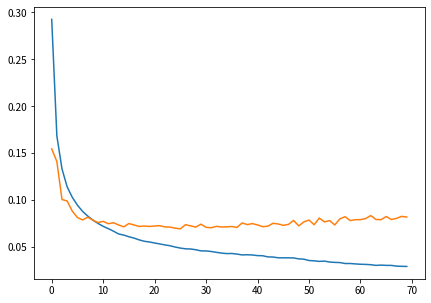

In [84]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(trainer.train_losses)), trainer.train_losses)
ax.plot(range(len(trainer.val_losses)), trainer.val_losses)
plt.show()

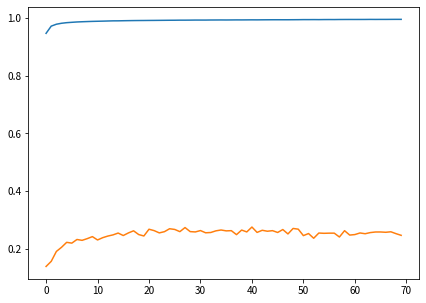

In [85]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(trainer.train_accs)), trainer.train_accs)
ax.plot(range(len(trainer.val_accs)), trainer.val_accs)
plt.show()

In [ ]:
print(trainer.validate(train_loader))
print(trainer.validate(val_loader))

## 予測結果

In [119]:
model_name = 'jam/wide_bn_drop3_balanced_Conv2d+LSTM'

In [120]:
model = Conv2dLSTM_Embedding(hid_dim, kernel_size).to(device=device)
model.load_state_dict(torch.load(f'{config.MODEL_DIR}/{model_name}_30.pth'))
model.eval()

Conv2dLSTM_Embedding(
  (dt_embed): Embedding(288, 32)
  (road_embed): Embedding(63, 16)
  (cat_fc): Linear(in_features=48, out_features=16, bias=True)
  (cat_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(4, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(64, 128, batch_first=True)
  (search_conv1): Conv2d(2, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (search_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (search_conv2): Conv2d(64, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (search_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (search_fc): Linear(in

In [121]:
def pred_data_generator(X_test, y_test, time_step, prediction_horizon):
    def create(zero_date, pred_start_date, pred_window, sec_id):
        pred_start_ind = int((pd.Timestamp(pred_start_date) - pd.Timestamp(zero_date)).total_seconds() / (60 * 60))
        pred_end_ind = pred_start_ind + pred_window

        in_start_ind = pred_start_ind - prediction_horizon - time_step + 1
        in_end_ind = pred_end_ind
        
        X_in = X_test[:, in_start_ind:in_end_ind, sec_id]
        y_in = y_test[:, in_start_ind:in_end_ind, sec_id]
        y_true = y_test[0, pred_start_ind:pred_end_ind, sec_id]
        
        return X_in, y_in, y_true
    return create

In [138]:
def predict(model, test_loader, device=device):
    model.eval()
    
    outs = []
    trues = []
    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            if isinstance(data, (list, tuple)):
                data = map(lambda x: x.to(device=device), data)
            else:
                data = data.to(device=device)
            out = model(data).detach().cpu()
            outs.append(out)
            trues.append(target)
    outs = torch.cat(outs, dim=0)
    trues = torch.cat(trues, dim=0)
    return outs, trues

In [123]:
p_gen = pred_data_generator(X_va, y_va, time_step=time_step, prediction_horizon=prediction_horizon)
zero_date = '2022/3/1'

### GW

In [142]:
pred_start_date = '2022/4/29'
pred_window = 9 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=range(len(sec_table)))
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [143]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [148]:
out, y_true = predict(model, test_loader)
_, predicted = torch.max(out, dim=1)

f1 = f1_score(y_true.flatten(), predicted)
print(f'f1 score: {f1 :.3f}')

f1 score: 0.299


In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(predicted)), predicted, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

### 普通の1週間 (月~日)

#### 3月

In [150]:
pred_start_date = '2022/3/21'
pred_window = 7 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=range(len(sec_table)))
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [151]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [154]:
out, y_true = predict(model, test_loader)
_, predicted = torch.max(out, dim=1)

f1 = f1_score(y_true.flatten(), predicted)
print(f'f1 score: {f1 :.3f}')

f1 score: 0.282


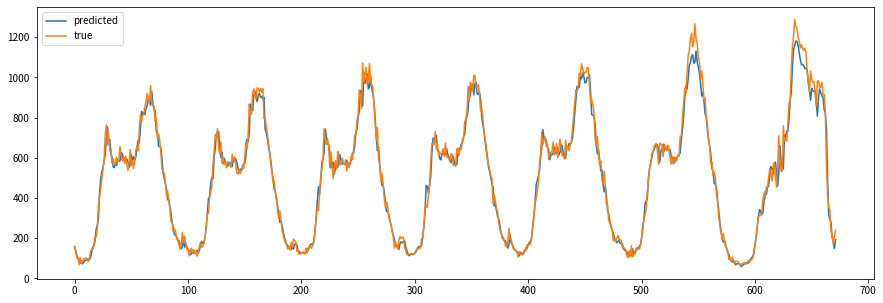

In [231]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 4月

In [155]:
pred_start_date = '2022/4/4'
pred_window = 7 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=range(len(sec_table)))
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [156]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [157]:
out, y_true = predict(model, test_loader)
_, predicted = torch.max(out, dim=1)

f1 = f1_score(y_true.flatten(), predicted)
print(f'f1 score: {f1 :.3f}')

f1 score: 0.185


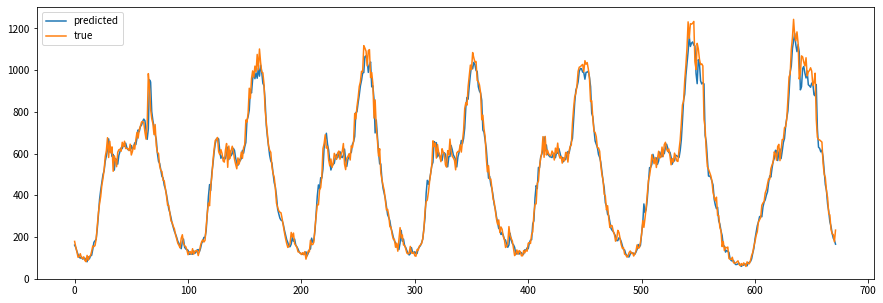

In [235]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 5月

In [158]:
pred_start_date = '2022/5/23'
pred_window = 7 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=range(len(sec_table)))
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [159]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [160]:
out, y_true = predict(model, test_loader)
_, predicted = torch.max(out, dim=1)

f1 = f1_score(y_true.flatten(), predicted)
print(f'f1 score: {f1 :.3f}')

f1 score: 0.347


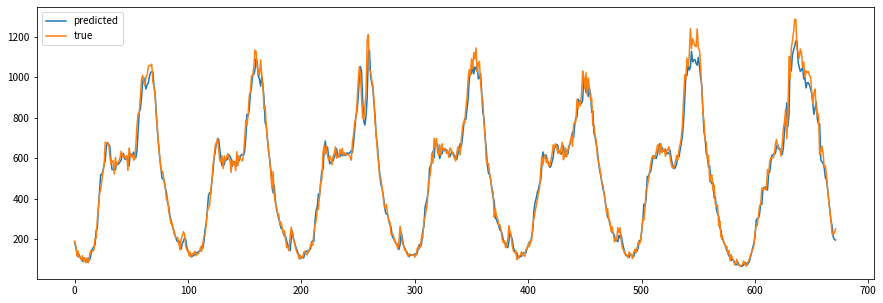

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()